In [1]:
import chaospy
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

## Tutorial for Point Collocation / Least Squares

In [9]:
def exponential_model(parameters, coordinates):
    param_init, param_rate = parameters
    return param_init*np.e**(-param_rate*coordinates)

In [10]:
def error_mean(prediction, truth):
    return np.mean(np.abs(prediction-truth))

In [11]:
distribution_init = chaospy.Normal(1.5, 0.2)
distribution_rate = chaospy.Uniform(0.1, 0.2)
distribution = chaospy.J(distribution_init, distribution_rate)

In [12]:
coordinates = np.linspace(0, 10, 8)

In [13]:
samples = distribution.sample(10, rule='halton')

In [14]:
evaluations = np.array([exponential_model(sample, coordinates)
                        for sample in samples.T])

In [15]:
poly_order = 4
poly_expansion = chaospy.orth_ttr(poly_order, distribution)

In [16]:
model_approximation = chaospy.fit_regression(poly_expansion, samples, evaluations)

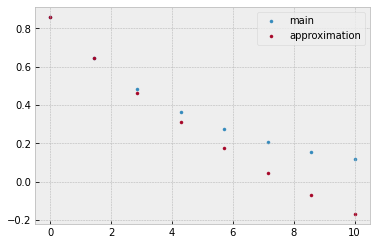

In [17]:
params = [0.86,0.2]

plt.scatter(coordinates,
            exponential_model(params, coordinates),
            marker='.', label="main")

plt.scatter(coordinates,
            model_approximation(*params, coordinates),
            marker='.', label="approximation")

plt.legend();

In [18]:
chaospy.Sens_m(model_approximation, distribution).round(2)

array([[1.  , 0.91, 0.72, 0.54, 0.4 , 0.3 , 0.24, 0.21],
       [0.  , 0.09, 0.27, 0.46, 0.59, 0.69, 0.75, 0.78]])

In [19]:
chaospy.Sens_t(model_approximation, distribution).round(2)

array([[1.  , 0.91, 0.73, 0.54, 0.41, 0.31, 0.25, 0.22],
       [0.  , 0.09, 0.28, 0.46, 0.6 , 0.7 , 0.76, 0.79]])

## Application to PyPSA-Eur Results

In [20]:
def load_data(fn, twkm_orig=289.65):
    df = pd.read_csv(fn, index_col=0, header=[0,1,2,3,4]).T
    df["offwind"] = df["offwind-ac"] + df["offwind-dc"]
    df["wind"] = df["onwind"] + df["offwind"]
    df["transmission"] = df["lines"] + df["links"] + twkm_orig
    df.drop(["ror", "hydro", 'PHS', 'offwind-ac', 'offwind-dc', 'lines', 'links'], axis=1, inplace=True)
    return df

In [23]:
df = load_data("../results/capacities-50halton.csv")

In [24]:
samples = np.array([np.array(idx).astype(float) for idx in df.index]).T

In [25]:
evaluations = df.values

In [26]:
dist = {}
dist["onwind"] = chaospy.Uniform(0.5, 1.5)
dist["offwind"] = chaospy.Uniform(0.5,1.5)
dist["solar"] = chaospy.Uniform(0.5, 1.5)
dist["H2"] = chaospy.Uniform(0.5, 1.5)
dist["battery"] = chaospy.Uniform(0.5,1.5)

distribution = chaospy.J(*dist.values())

In [79]:
def build_surrogate(order, distribution, samples, evaluations):
    pce = chaospy.orth_ttr(order, distribution, normed=False, cross_truncation=1.)
    return chaospy.fit_regression(pce, samples, evaluations)

In [ ]:
surrogates = {}
# TODO: what order is good?
for order in list(range(10)):
    print(order)
    # TODO: what are good choices for normed and cross_truncation?
    pce = chaospy.orth_ttr(order, distribution, normed=False, cross_truncation=1.)
    surrogates[order] = build_surrogate(order, distribution, samples, evaluations)

0
1
2
3
4
5
6
7
8
9


In [56]:
predict = np.array([surrogates[6](*s) for s in samples.T])

In [57]:
dfp = pd.DataFrame(predict, index=df.index, columns=df.columns)

In [58]:
predict2 = np.array([surrogates[2](*s) for s in samples.T])

In [59]:
dfp2 = pd.DataFrame(predict2, index=df.index, columns=df.columns)

### Evaluation

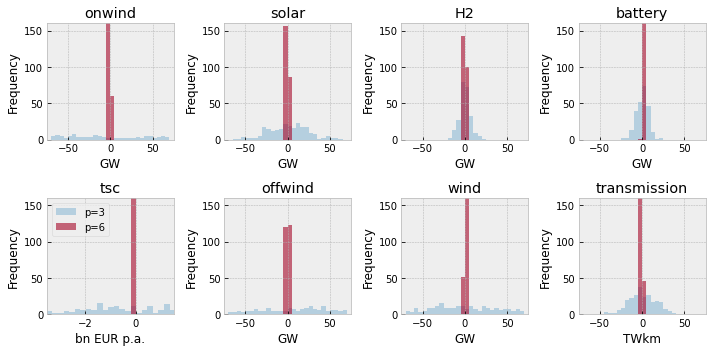

In [60]:
fig, axes = plt.subplots(2,4,figsize=(10,5))
for i, c in enumerate(df.columns):
    ax = axes[int(i/4)][i%4]
    ax.set_title(c)
    ax.set_ylim([0,160])
    bins = np.arange(-70,71,5)
    if c == "tsc":
        ax.set_xlim([-3.5,1.5])
        ax.set_xlabel("bn EUR p.a.")
        bins = np.arange(-3.5,1.6,0.22)
    elif c == "transmission":
        ax.set_xlim([-75,75])
        ax.set_xlabel("TWkm")
    else:
        ax.set_xlim([-75,75])
        ax.set_xlabel("GW")
    (dfp2 - df)[c].plot.hist(ax=ax, label="p=3", alpha=0.3, bins=bins)
    (dfp - df)[c].plot.hist(ax=ax, label="p=6", alpha=0.6, bins=bins)
plt.tight_layout()

axes[1,0].legend();
#plt.savefig("errors.pdf", bbox_inches='tight')

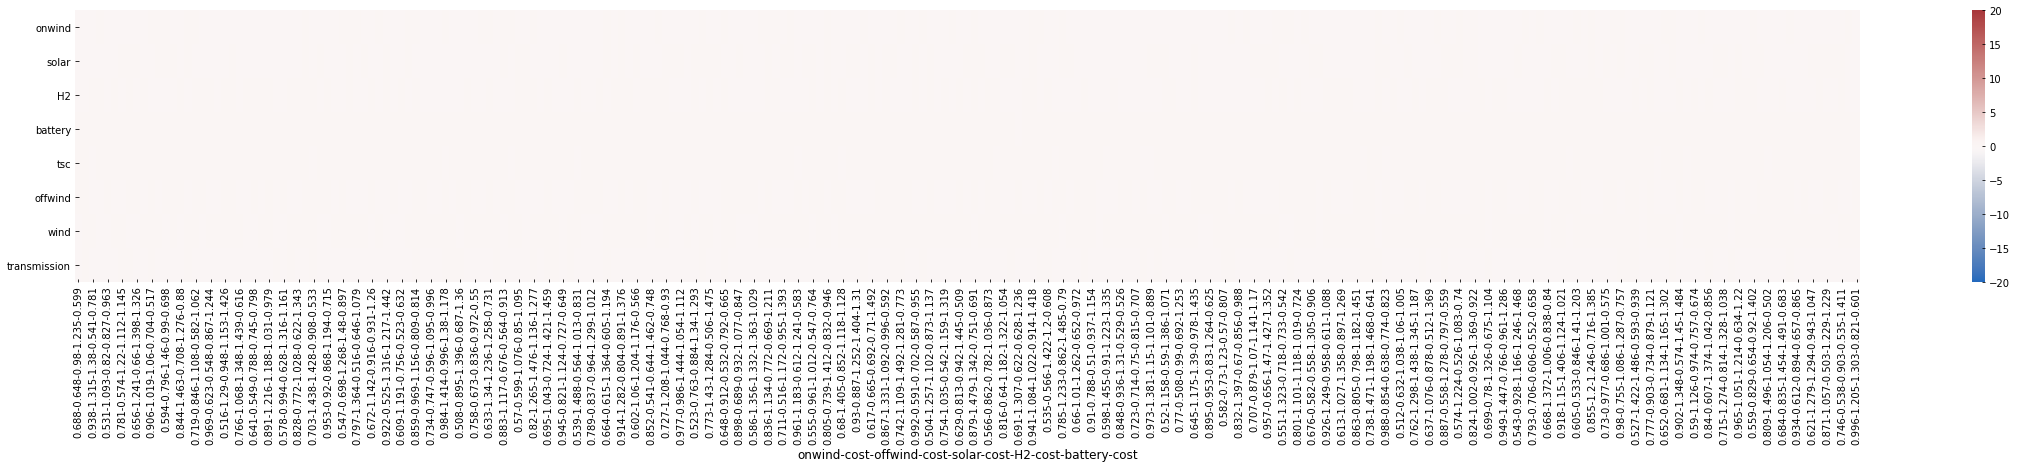

In [61]:
fig, ax = plt.subplots(figsize=(40,5))
sns.heatmap((dfp - df).T, cmap='vlag', vmin=-20, vmax=20)

In [62]:
rel_error = (dfp - df).abs().mean() / df.mean() * 100
rel_error

onwind          2.727717e-11
solar           8.846334e-12
H2              6.783487e-12
battery         7.774431e-11
tsc             2.568173e-12
offwind         4.230872e-11
wind            7.766051e-12
transmission    6.936277e-12
dtype: float64

In [63]:
rmse = ((dfp - df)**2).mean()**0.5
rmse

onwind          2.077307e-10
solar           4.541076e-11
H2              1.052210e-11
battery         3.416713e-11
tsc             6.083881e-12
offwind         1.432373e-10
wind            8.716624e-11
transmission    5.844577e-11
dtype: float64

In [64]:
abs_error = (dfp - df).abs().mean()
abs_error

onwind          1.571258e-10
solar           3.461674e-11
H2              8.019864e-12
battery         3.094844e-11
tsc             5.017309e-12
offwind         1.091975e-10
wind            6.477904e-11
transmission    4.723524e-11
dtype: float64

In [67]:
surrogate = surrogates[4]

In [68]:
# can take a while for order > 3
sobol = chaospy.Sens_m(surrogate, distribution).round(3)
sobol = pd.DataFrame(sobol, index=[f"{k}-cost" for k in dist.keys()], columns=df.columns)
sobol

KeyboardInterrupt: 

In [1092]:
# can take a while for order > 3
sobolt = chaospy.Sens_t(surrogate, distribution).round(3)
sobolt = pd.DataFrame(sobolt, index=[f"{k}-cost" for k in dist.keys()], columns=df.columns)
sobolt

,onwind,solar,H2,battery,tsc,offwind,wind,transmission
onwind-cost,0.020,0.588,0.020,0.119,0.054,0.014,0.116,0.133
offwind-cost,0.606,0.206,0.010,0.047,0.503,0.338,0.779,0.304
solar-cost,0.380,0.258,0.025,0.099,0.433,0.670,0.121,0.304
H2-cost,0.000,0.008,0.853,0.344,0.088,0.001,0.003,0.338
battery-cost,0.001,0.015,0.114,0.474,0.004,0.001,0.006,0.011


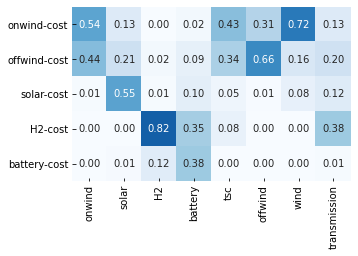

In [38]:
fig, ax = plt.subplots(figsize=(5,8))
sns.heatmap(sobol, square=True, cmap="Blues", vmax=1, vmin=0, annot=True, fmt=".2f", cbar=False);
#plt.savefig("sobol-first.pdf", bbox_inches='tight')

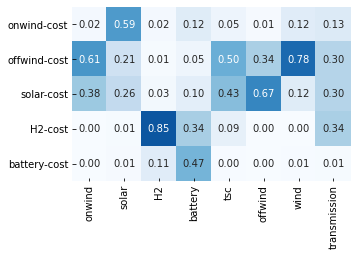

In [1094]:
fig, ax = plt.subplots(figsize=(5,8))
sns.heatmap(sobolt, square=True, cmap="Blues", vmax=1, vmin=0, annot=True, fmt=".2f", cbar=False);
#plt.savefig("sobol-total.pdf", bbox_inches='tight')

## Validate Surrogate Model

In [69]:
df_val = load_data("../results/capacities-25.csv")

In [70]:
samples_val = np.array([np.array(idx).astype(float) for idx in df_val.index]).T

In [75]:
predict_val = np.array([surrogates[6](*s) for s in samples_val.T])

In [76]:
dfp_val = pd.DataFrame(predict_val, index=df_val.index, columns=df_val.columns)

In [77]:
dfp_val

onwind  \
solar-cost onwind-cost offwind-cost H2-cost battery-cost               
0.75       0.75        0.75         0.75    0.75          657.855578   
                                            1.0           630.302262   
                                            1.25          608.587910   
                                    1.0     0.75          582.949088   
                                            1.0           588.311944   
...                                                              ...   
1.25       1.25        1.25         1.0     1.0           600.877344   
                                            1.25          564.532979   
                                    1.25    0.75          579.556513   
                                            1.0           624.466279   
                                            1.25          664.714326   

                                                               solar  \
solar-cost onwind-cost offwind-cost H2-cost battery-cost               
0.75       0.75        0.75         0.75    0.75          441.078623   
                                            1.0           397.153242   
                                            1.25          365.324273   
                                    1.0     0.75          451.409616   
                                            1.0           413.519842   
...                                                              ...   
1.25       1.25        1.25         1.0     1.0           426.940452   
                                            1.25          389.991372   
                                    1.25    0.75          439.712657   
                                            1.0           440.535355   
                                            1.25          430.631088   

                                                                  H2  \
solar-cost onwind-cost offwind-cost H2-cost battery-cost               
0.75       0.75        0.75         0.75    0.75          118.440494   
                                            1.0           134.141922   
                                            1.25          149.215569   
                                    1.0     0.75           92.161454   
                                            1.0            99.651622   
...                                                              ...   
1.25       1.25        1.25         1.0     1.0           114.131309   
                                            1.25          130.471836   
                                    1.25    0.75           86.604757   
                                            1.0            91.765940   
                                            1.25           93.553477   

                                                            battery  \
solar-cost onwind-cost offwind-cost H2-cost battery-cost              
0.75       0.75        0.75         0.75    0.75          41.708193   
                                            1.0           19.874852   
                                            1.25          -5.031868   
                                    1.0     0.75          54.912955   
                                            1.0           41.145303   
...                                                             ...   
1.25       1.25        1.25         1.0     1.0           48.193411   
                                            1.25          31.974626   
                                    1.25    0.75          76.488908   
                                            1.0           60.157803   
                                            1.25          57.165721   

                                                                 tsc  \
solar-cost onwind-cost offwind-cost H2-cost battery-cost               
0.75       0.75        0.75         0.75    0.75          168.873233   
                                            1.0           168.718450   
                                       

In [78]:
rel_error = (dfp_val - df_val).abs().mean() / df.mean() * 100
rel_error

onwind           88.664744
solar            48.067299
H2                6.731800
battery          39.842358
tsc               4.616397
offwind         116.120152
wind             26.080989
transmission      4.070675
dtype: float64